<a href="https://colab.research.google.com/github/basugautam/Reproducibility-Challenge-Project/blob/Architecture-Files/1_autoformer_energy_consumption_loss__shaping__constant_growth__replica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-04-10 05:51:12--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10360719 (9.9M) [text/plain]
Saving to: ‘ETTm1.csv.5’

ETTm1.csv.5         100%[===================>]   9.88M  53.9MB/s    in 0.2s    

2025-04-10 05:51:13 (53.9 MB/s) - ‘ETTm1.csv.5’ saved [10360719/10360719]



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 7])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 7])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.025741550111212905
Epoch [2/10], Loss: 0.02514659105046266
Epoch [3/10], Loss: 0.025137500507044944
Epoch [4/10], Loss: 0.02513274904254965
Epoch [5/10], Loss: 0.025130963149714688
Epoch [6/10], Loss: 0.02512751943854151
Epoch [7/10], Loss: 0.025124994230624524
Epoch [8/10], Loss: 0.025124265900016447
Epoch [9/10], Loss: 0.025124896139154546
Epoch [10/10], Loss: 0.025114866490042784


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([24, 7])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.027433542843008862


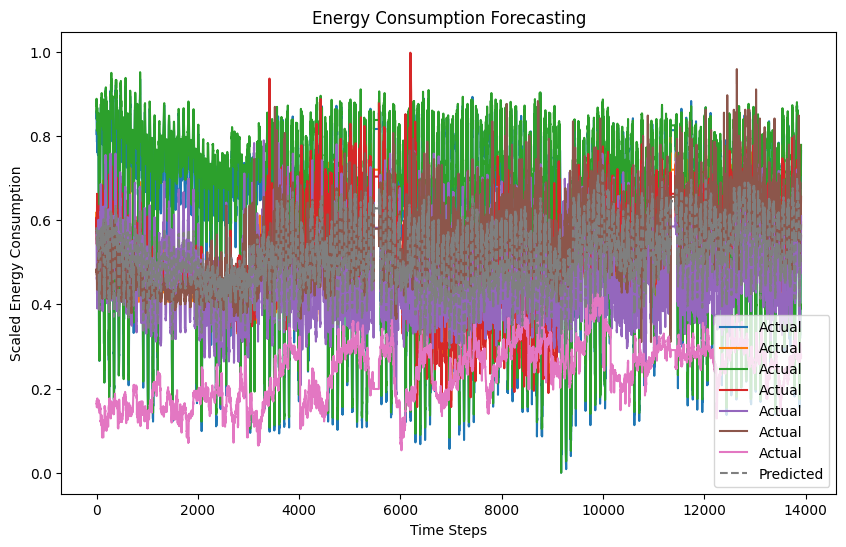

In [2]:
# Step 1: Importing Required Libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Explanation:
# - `torch` is the core deep learning library for creating and training neural networks.
# - `pandas` is used for handling and manipulating data.
# - `numpy` is useful for numerical operations on data arrays.
# - `MinMaxScaler` will scale the data to a range of 0 to 1, which is typical for time-series forecasting tasks.
# - `Dataset` and `DataLoader` from PyTorch will help us structure the data into sequences for model training.
# - `mean_absolute_error` and `mean_squared_error` are used to evaluate the forecasting model.
# - `matplotlib` will be used for plotting results.

# Step 2: Download the Dataset
!wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv

# Step 3: Load and Preprocess the Data
dataset_file = 'ETTm1.csv'  # Path to the downloaded dataset
data = pd.read_csv(dataset_file)

# Explanation:
# The dataset is loaded into a DataFrame, a tabular format that is easy to manipulate and clean. This is essential for preparing the data for time-series forecasting models.

# Handle missing values (if any) and remove irrelevant columns (such as datetime)
data = data.dropna()  # Remove rows with missing values

# Check if 'timestamp' column exists and drop it (since it's not useful for training)
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])  # Drop datetime column, which is not needed for forecasting

# Step 4: MinMax Scaling the Data
# Now we scale only the numerical columns, excluding the datetime column (if present) to avoid errors.

# Identify the numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Only scale the numeric columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[numeric_columns])  # Scale the numerical data only

# Explanation:
# MinMaxScaler scales the data to a range between 0 and 1. This ensures that features with large values do not dominate the training process and helps the model converge more efficiently.

# Step 5: Prepare Data for Time-Series Forecasting
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=24):
        """
        Args:
            data (numpy array): The scaled time-series data
            lookback (int): The number of past observations used to predict the future value
        """
        self.data = data
        self.lookback = lookback

    def __len__(self):
        return len(self.data) - self.lookback  # Number of sequences

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.lookback]  # Past observations (lookback window)
        y = self.data[idx + self.lookback]  # Future value (target)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Step 6: Split Data into Training and Testing Sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create datasets for training and testing
train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

# Step 7: Create DataLoader for Efficient Batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 8: Build the Informer Model for Energy Consumption Forecasting
class InformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(InformerModel, self).__init__()

        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        output = self.fc(last_time_step_out)
        return output

# Step 9: Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InformerModel(input_dim=train_data.shape[1], hidden_dim=64, output_dim=1).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}")

# Step 10: Evaluate the Model
model.eval()
with torch.no_grad():
    test_loss = 0
    predictions = []
    targets = []
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(x_batch)

        # Compute the loss
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy())

    print(f"Test Loss: {test_loss/len(test_loader)}")

    # Plotting the Results
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Plot the predicted vs actual values
    plt.figure(figsize=(10,6))
    plt.plot(targets, label='Actual')
    plt.plot(predictions, label='Predicted', linestyle='--')
    plt.legend()
    plt.title('Energy Consumption Forecasting')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Energy Consumption')
    plt.show()

